In [1]:
!pip install Flask tensorflow pandas numpy matplotlib yfinance scikit-learn


  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
   ---------------------------------------- 0.0/101.7 kB ? eta -:--:--
   ---------------------------------------- 101.7/101.7 kB 1.9 MB/s eta 0:00:00
Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
   ---------------------------------------- 0.0/895.7 kB ? eta -:--:--
   -------------------- ------------------ 460.8/895.7 kB 14.1 MB/s eta 0:00:01
   --------------------------------------- 895.7/895.7 kB 11.2 MB/s eta 0:00:00
Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
   ---------------------------------------- 0.0/227.6 kB ? eta -:--:--
   ---------------------------------------- 227.6/227.6 kB ? eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.8
    Uninstalling Werkzeug-2.3.8:
      Successfully uninstalled Werkzeug-

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.4 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 3.19.6 which is incompatible.


Overwriting app.py


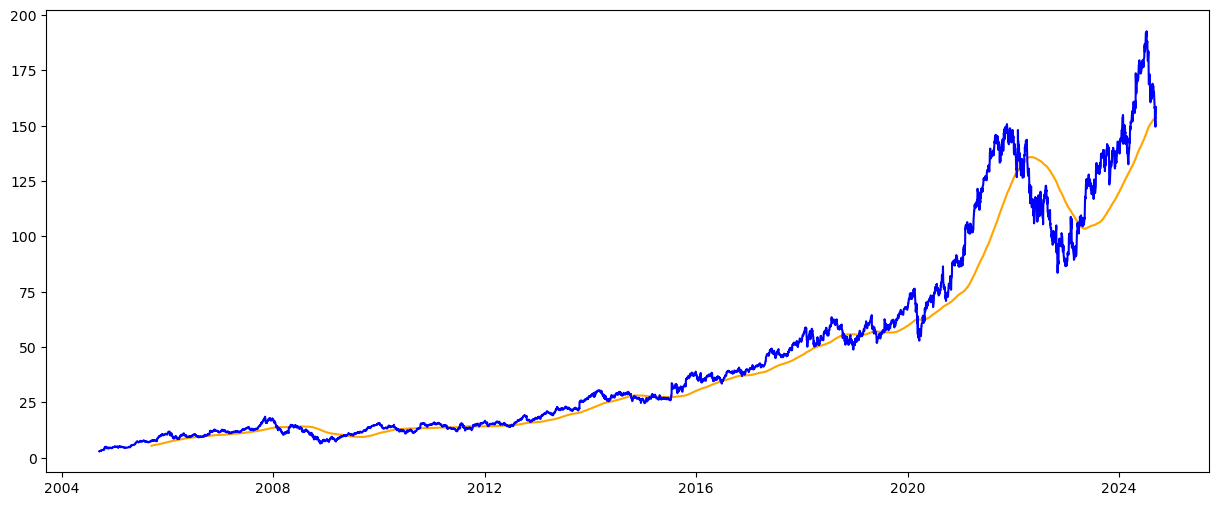

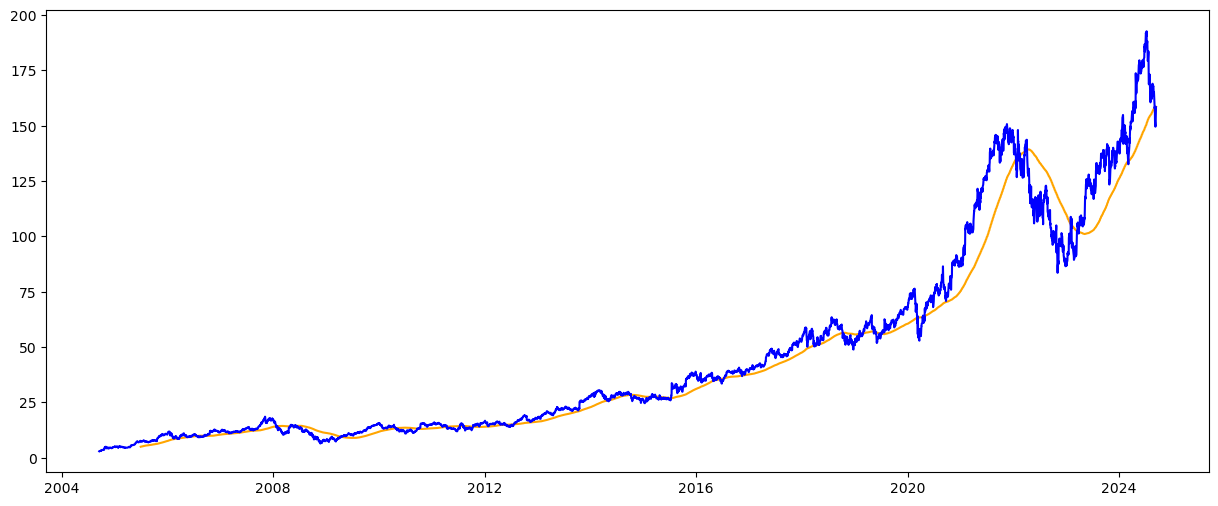

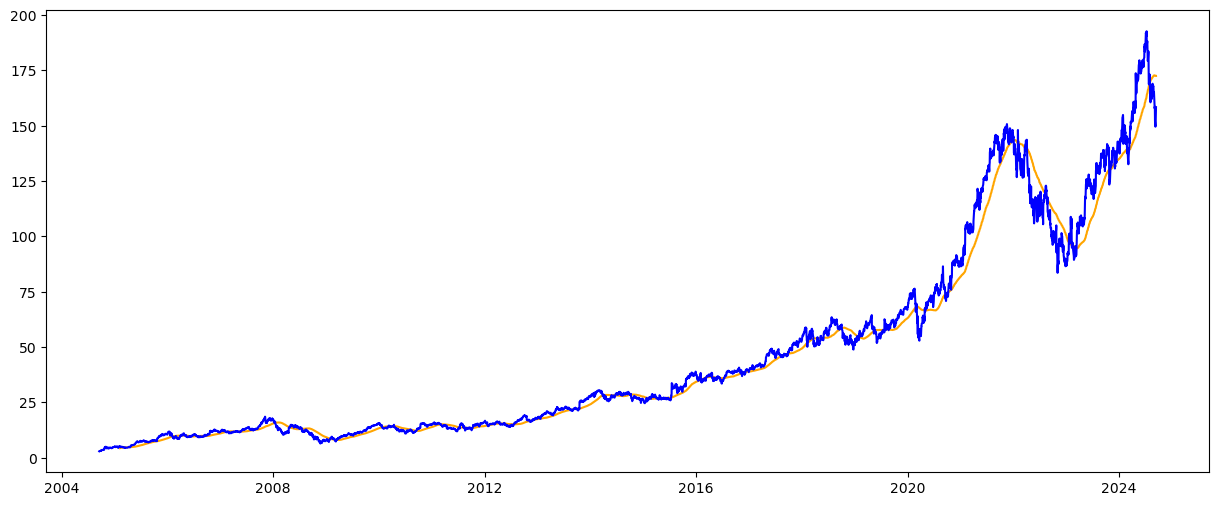

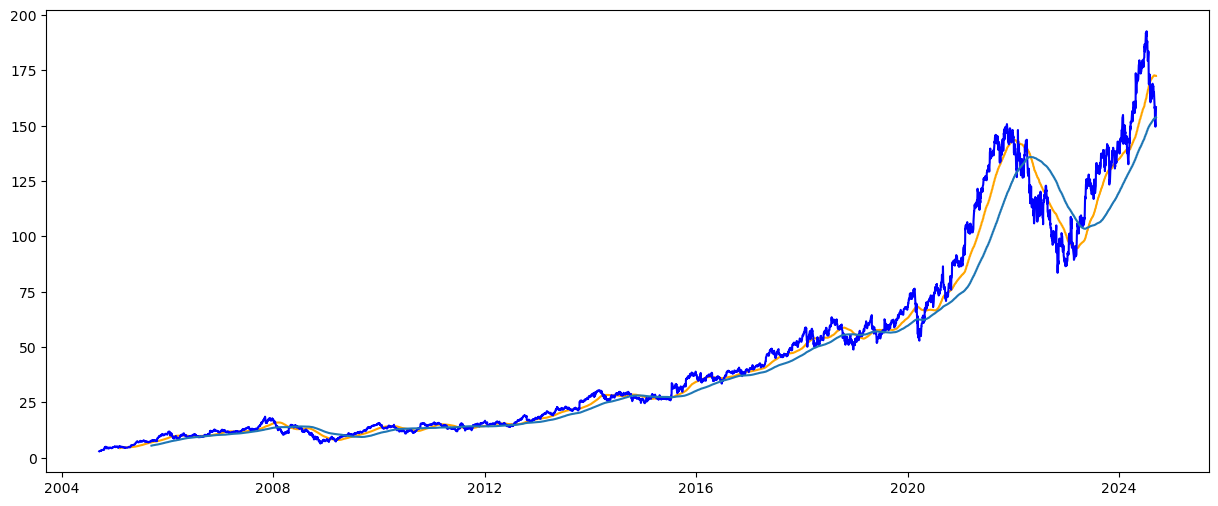

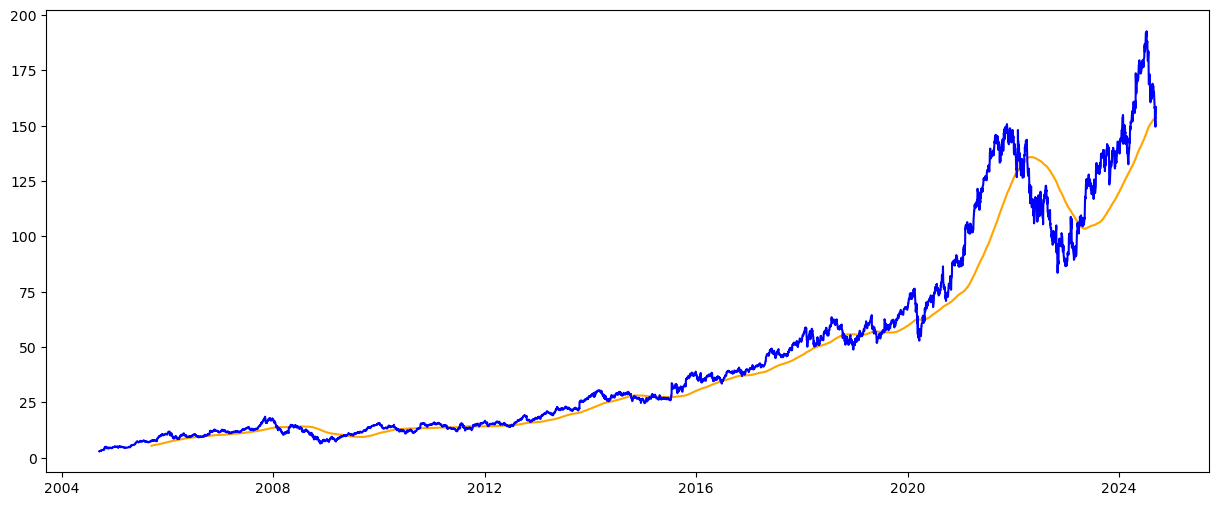

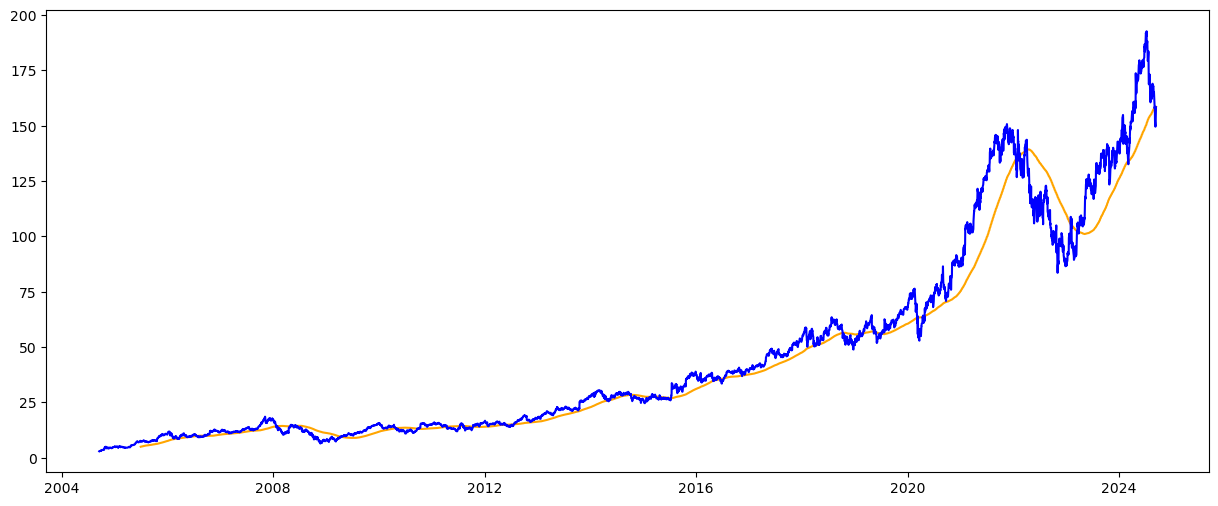

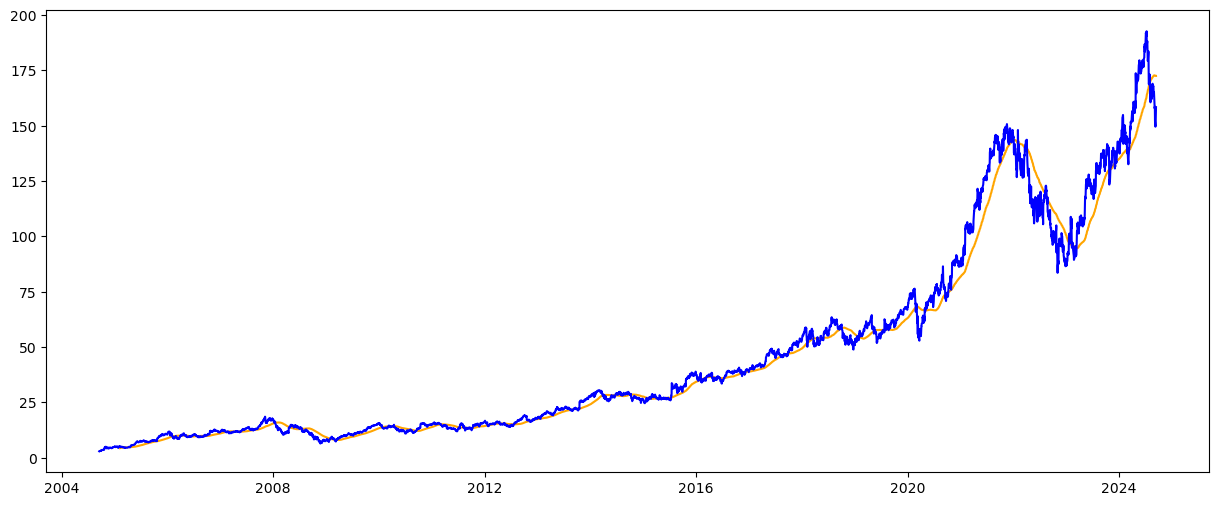

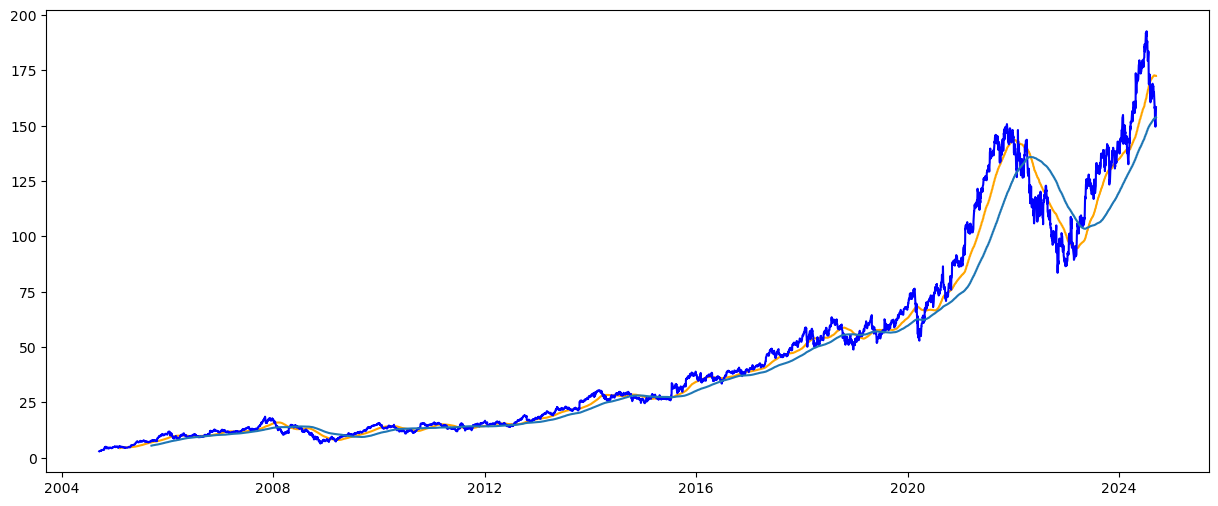

In [11]:
%%writefile app.py
from flask import Flask, request, jsonify, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import io
import base64

app = Flask(__name__)

# Load the model
MODEL_PATH = "9. Projects/Latest_stock_price_model.keras"
model = tf.keras.models.load_model(MODEL_PATH)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    stock = request.form.get("stock", "GOOG")

    from datetime import datetime
    end = datetime.now()
    start = datetime(end.year-20, end.month, end.day)

    google_data = yf.download(stock, start, end)

    splitting_len = int(len(google_data)*0.7)
    x_test = pd.DataFrame(google_data.Close[splitting_len:])

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(x_test[['Close']])

    x_data = []
    y_data = []

    for i in range(100, len(scaled_data)):
        x_data.append(scaled_data[i-100:i])
        y_data.append(scaled_data[i])

    x_data, y_data = np.array(x_data), np.array(y_data)

    predictions = model.predict(x_data)

    inv_pre = scaler.inverse_transform(predictions)
    inv_y_test = scaler.inverse_transform(y_data)

    ploting_data = pd.DataFrame(
        {
            'original_test_data': inv_y_test.reshape(-1),
            'predictions': inv_pre.reshape(-1)
        },
        index=google_data.index[splitting_len+100:]
    )

    def plot_graph(values, full_data, extra_data=None, extra_dataset=None):
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.plot(values, 'Orange')
        ax.plot(full_data.Close, 'b')
        if extra_data:
            ax.plot(extra_dataset)
        return fig

    def get_img_base64(fig):
        img = io.BytesIO()
        fig.savefig(img, format='png')
        img.seek(0)
        return base64.b64encode(img.getvalue()).decode('utf-8')

    google_data['MA_for_100_days'] = google_data.Close.rolling(100).mean()
    fig1 = plot_graph(google_data['MA_for_100_days'], google_data)
    ma_250_img = get_img_base64(fig1)

    google_data['MA_for_100_days'] = google_data.Close.rolling(200).mean()
    fig2 = plot_graph(google_data['MA_for_100_days'], google_data)
    ma_200_img = get_img_base64(fig2)

    google_data['MA_for_100_days'] = google_data.Close.rolling(100).mean()
    fig3 = plot_graph(google_data['MA_for_100_days'], google_data)
    ma_100_img = get_img_base64(fig3)

    fig4 = plot_graph(google_data['MA_for_100_days'], google_data, extra_data=1, extra_dataset=google_data['MA_for_250_days'])
    ma_100_250_img = get_img_base64(fig4)

    fig5 = plt.figure(figsize=(15, 6))
    plt.plot(pd.concat([google_data.Close[:splitting_len+100], ploting_data], axis=0))
    plt.legend(["Data - not used", "Original Test data", "Predicted Test data"])
    plt.close(fig5)
    original_vs_predicted_img = get_img_base64(fig5)

    return render_template(
        'result.html',
        original_data=google_data.to_html(),
        ma_250_img=ma_250_img,
        ma_200_img=ma_200_img,
        ma_100_img=ma_100_img,
        ma_100_250_img=ma_100_250_img,
        original_vs_predicted_img=original_vs_predicted_img
    )

if __name__ == '__main__':
    app.run(debug=True)


In [12]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Stock Price Predictor</title>
</head>
<body>
    <h1>Stock Price Predictor App</h1>
    <form action="/predict" method="post">
        <label for="stock">Enter the Stock ID:</label>
        <input type="text" id="stock" name="stock" value="GOOG">
        <button type="submit">Predict</button>
    </form>
</body>
</html>


Overwriting templates/index.html


In [13]:
%%writefile templates/result.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Prediction Results</title>
</head>
<body>
    <h1>Stock Price Prediction Results</h1>
    <h2>Stock Data</h2>
    <div>{{ original_data|safe }}</div>

    <h2>Moving Averages</h2>
    <img src="data:image/png;base64,{{ ma_250_img }}" alt="MA for 250 days">
    <img src="data:image/png;base64,{{ ma_200_img }}" alt="MA for 200 days">
    <img src="data:image/png;base64,{{ ma_100_img }}" alt="MA for 100 days">
    <img src="data:image/png;base64,{{ ma_100_250_img }}" alt="MA for 100 and 250 days">

    <h2>Original vs Predicted Close Price</h2>
    <img src="data:image/png;base64,{{ original_vs_predicted_img }}" alt="Original vs Predicted Close Price">
</body>
</html>


Overwriting templates/result.html


In [14]:
import threading
from app import app  # Import the Flask app object

def run_flask():
    app.run(debug=True, use_reloader=False)  # Run the Flask app

# Start the Flask server in a new thread
thread = threading.Thread(target=run_flask)
thread.start()


 * Serving Flask app 'app'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [16/Sep/2024 13:25:48] "GET / HTTP/1.1" 200 -
[*********************100%***********************]  1 of 1 completed

 3/45 [=>............................] - ETA: 1s

45/45 [==============================] - 2s 48ms/step


127.0.0.1 - - [16/Sep/2024 13:25:56] "POST /predict HTTP/1.1" 200 -
